In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import joblib
import os
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

# Create a custom transformer for sentence embeddings
class SentenceTransformerEmbedding(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return self.model.encode(X)
# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize, remove stopwords and lemmatize (optional - can be computational intensive)
    # Uncomment if you want this feature
    '''
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    '''
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

class TextEmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long)

# LSTM-RNN-GRU Series Model
class SeriesNeuralClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, dropout=0.2):
        super(SeriesNeuralClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, 
                            num_layers=1, dropout=0, 
                            batch_first=True)
        
        # RNN layer
        self.rnn = nn.RNN(hidden_dim, hidden_dim, 
                          num_layers=1, dropout=0, 
                          batch_first=True)
        
        # GRU layer
        self.gru = nn.GRU(hidden_dim, hidden_dim, 
                          num_layers=1, dropout=0, 
                          batch_first=True)
        
        # Final fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text shape: [batch size, embedding dim]
        # Reshaping to [batch size, 1, embedding dim] to simulate sequence length of 1
        text = text.unsqueeze(1)
        
        # Pass through LSTM
        lstm_out, (lstm_hidden, lstm_cell) = self.lstm(text)
        
        # Pass LSTM output through RNN
        rnn_out, rnn_hidden = self.rnn(lstm_out)
        
        # Pass RNN output through GRU
        gru_out, gru_hidden = self.gru(rnn_out)
        
        # Take the last hidden state from GRU
        hidden = gru_hidden[-1]
        hidden = self.dropout(hidden)
        
        # Pass through final layer
        output = self.fc(hidden)
        return output

class PyTorchSeriesNeuralWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=384, hidden_dim=128, dropout=0.2, n_layers=1, 
                 lr=0.001, epochs=10, batch_size=32, device=None):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.n_layers = n_layers
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.label_encoder = None
        self.classes_ = None
    
    def fit(self, X, y):
        # Encode labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_
        
        # Create dataset and loader
        dataset = TextEmbeddingDataset(X, y_encoded)
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Initialize model
        self.output_dim = len(self.label_encoder.classes_)
        self.model = SeriesNeuralClassifier(
            input_dim=self.input_dim, 
            hidden_dim=self.hidden_dim,
            output_dim=self.output_dim,
            n_layers=self.n_layers,
            dropout=self.dropout
        ).to(self.device)
        
        # Define optimizer and loss
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            print(f'Epoch {epoch+1}/{self.epochs}, Loss: {total_loss/len(train_loader):.4f}')
        
        return self
    
    def predict(self, X):
        self.model.eval()
        predictions = []
        
        # Create dataset and loader for predictions
        dummy_y = np.zeros(len(X))
        dataset = TextEmbeddingDataset(X, dummy_y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
        
        return self.label_encoder.inverse_transform(predictions)
    
    def predict_proba(self, X):
        self.model.eval()
        probabilities = []
        
        # Create dataset and loader for predictions
        dummy_y = np.zeros(len(X))
        dataset = TextEmbeddingDataset(X, dummy_y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                probabilities.extend(probs.cpu().numpy())
        
        return np.array(probabilities)

# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your English dataset
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_english_classifier(train_file, test_file=None):
    """
    Train an English text classifier using LSTM-RNN-GRU series and evaluate on test data.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_english_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('training_class_distribution.png')
        print("Class distribution plot saved as 'training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create a pipeline with Sentence Transformer embeddings and LSTM-RNN-GRU series model
        print("\nCreating and training the LSTM-RNN-GRU series model...")
        pipeline = Pipeline([
            ('embeddings', SentenceTransformerEmbedding()),
            ('classifier', PyTorchSeriesNeuralWrapper(
                input_dim=384,  # Default dimension for all-MiniLM-L6-v2
                hidden_dim=128,
                dropout=0.3,
                n_layers=2,
                lr=0.001,
                epochs=30,
                batch_size=32
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("LSTM-RNN-GRU series model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text
            print("Preprocessing test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_english_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix.png')
            print("Confusion matrix saved as 'confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions.csv', index=False)
            print("Test predictions saved to 'test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence (probability of the predicted class)
        confidence_values = []
        for i, pred_class in enumerate(predictions_class):
            class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
            confidence_values.append(prediction_probs[i][class_index])
        
        df['prediction_confidence'] = confidence_values
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def save_model(model, model_path='english_series_classifier_model.pkl'):
    """
    Save the trained model to a file
    
    Args:
        model: Trained classifier pipeline
        model_path: Path where to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model_and_predict(model_path='english_series_classifier_model.pkl', 
                          test_file=None, sample_text=None):
    """
    Load a trained model and use it for inference on a test file or sample text
    
    Args:
        model_path: Path to the saved model file
        test_file: Path to a CSV file containing texts to predict
        sample_text: A single text string to predict
        
    Returns:
        Predictions or a single prediction
    """
    try:
        # Load the model
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        
        if test_file and os.path.exists(test_file):
            # Predict on test file
            print(f"Predicting on test file: {test_file}")
            df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess text
            df['processed_text'] = df['text'].apply(preprocess_english_text)
            
            # Make predictions
            predictions_class = model.predict(df['processed_text'])
            predictions_value = [float(pred) for pred in predictions_class]
            
            # Get prediction probabilities
            prediction_probs = model.predict_proba(df['processed_text'])
            
            # Add predictions to dataframe
            df['predicted_label_class'] = predictions_class
            df['predicted_label_value'] = predictions_value
            
            # Add prediction confidence
            confidence_values = []
            for i, pred_class in enumerate(predictions_class):
                class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
                confidence_values.append(prediction_probs[i][class_index])
            
            df['prediction_confidence'] = confidence_values
            
            # Save results
            output_file = "series_model_predictions_output.csv"
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
            
            return df
            
        elif sample_text:
            # Predict on a single text
            print("Predicting on sample text...")
            processed_text = preprocess_english_text(sample_text)
            prediction_class = model.predict([processed_text])[0]
            prediction_value = float(prediction_class)
            
            # Get prediction probability
            prediction_prob = model.predict_proba([processed_text])[0]
            class_index = list(model.named_steps['classifier'].classes_).index(prediction_class)
            confidence = prediction_prob[class_index]
            
            print(f"Text: {sample_text}")
            print(f"Processed text: {processed_text}")
            print(f"Prediction (class): {prediction_class}")
            print(f"Prediction (value): {prediction_value}")
            print(f"Confidence: {confidence:.4f}")
            
            return prediction_class, prediction_value, confidence
        
        else:
            print("Error: Please provide either a test file or sample text.")
            return None
            
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()
        return None

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv...
Preprocessing training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    5269
1.0    1262
Name: count, dtype: int64
Class distribution plot saved as 'training_class_distribution.png'

Creating and training the LSTM-RNN-GRU series model...


Batches:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.4332
Epoch 2/30, Loss: 0.3804
Epoch 3/30, Loss: 0.3729
Epoch 4/30, Loss: 0.3689
Epoch 5/30, Loss: 0.3616
Epoch 6/30, Loss: 0.3622
Epoch 7/30, Loss: 0.3581
Epoch 8/30, Loss: 0.3561
Epoch 9/30, Loss: 0.3465
Epoch 10/30, Loss: 0.3415
Epoch 11/30, Loss: 0.3338
Epoch 12/30, Loss: 0.3228
Epoch 13/30, Loss: 0.3133
Epoch 14/30, Loss: 0.2982
Epoch 15/30, Loss: 0.2802
Epoch 16/30, Loss: 0.2621
Epoch 17/30, Loss: 0.2401
Epoch 18/30, Loss: 0.2134
Epoch 19/30, Loss: 0.1839
Epoch 20/30, Loss: 0.1520
Epoch 21/30, Loss: 0.1311
Epoch 22/30, Loss: 0.1059
Epoch 23/30, Loss: 0.0944
Epoch 24/30, Loss: 0.0779
Epoch 25/30, Loss: 0.0623
Epoch 26/30, Loss: 0.0708
Epoch 27/30, Loss: 0.0488
Epoch 28/30, Loss: 0.0431
Epoch 29/30, Loss: 0.0299
Epoch 30/30, Loss: 0.0497
LSTM-RNN-GRU series model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv...
Preprocessing test text...
Calculating majority vote for test labels...
Making predictions on 

Batches:   0%|          | 0/35 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.6632

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86       877
         1.0       0.46      0.48      0.47       230

    accuracy                           0.78      1107
   macro avg       0.66      0.67      0.66      1107
weighted avg       0.78      0.78      0.78      1107

Confusion matrix saved as 'confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'test_predictions.csv'
Saving model to english_series_classifier_model_l1.pkl...
Model saved successfully to english_series_classifier_model_l1.pkl
Loading model from english_series_classifier_model_l1.pkl...
Model loaded successfully!
Predicting on sample text...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:714: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.rnn_tanh(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly gre

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: Your sample text here
Processed text: your sample text here
Prediction (class): 0.0
Prediction (value): 0.0
Confidence: 1.0000
Class: 0.0, Value: 0.0, Confidence: 1.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:714: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.rnn_tanh(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly gre

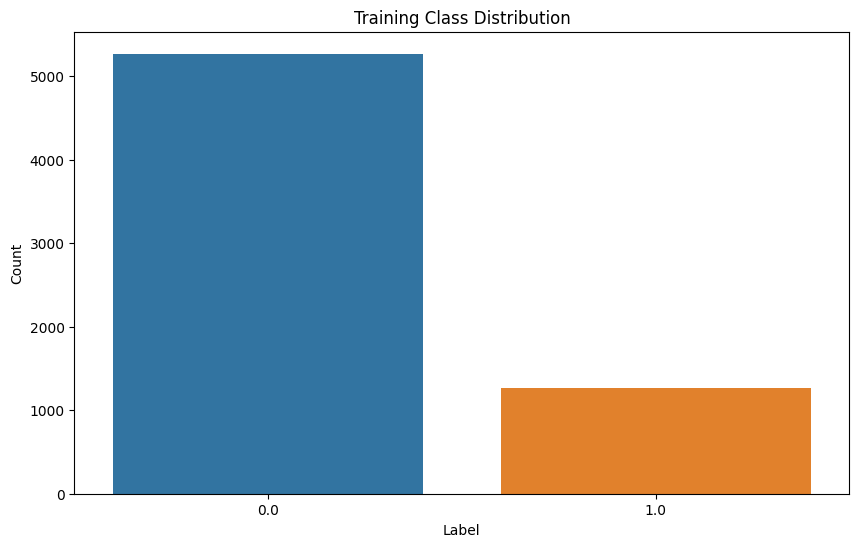

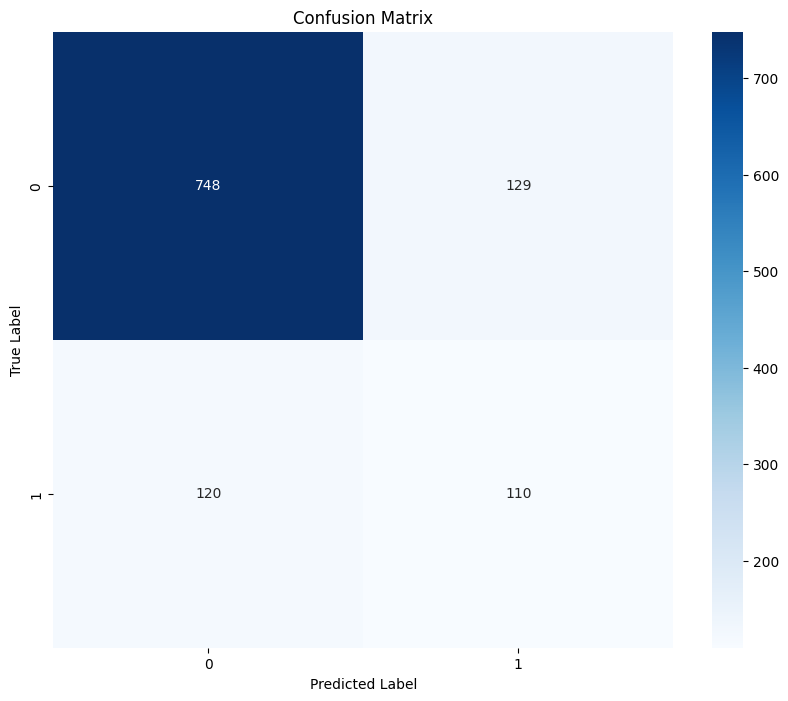

In [12]:
# Option 1: Training
train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv"
test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv"
model, f1, report = train_english_classifier(train_file, test_file)
save_model(model, "english_series_classifier_model_l1.pkl")

# Option 2: Prediction
#model = joblib.load("english_series_classifier_model_l1.pkl")
#input_file = "/kaggle/input/your-dataset/new_data.csv"
#output_file = "predictions.csv"
#predict_on_new_data(model, input_file, output_file)

# Option 3: Sample prediction
model_path = "english_series_classifier_model_l1.pkl"
sample_text = "Your sample text here"
prediction_class, prediction_value, confidence = load_model_and_predict(
    model_path=model_path, sample_text=sample_text)
print(f"Class: {prediction_class}, Value: {prediction_value}, Confidence: {confidence:.4f}")

In [13]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import joblib
import os
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

# Create a custom transformer for sentence embeddings
class SentenceTransformerEmbedding(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return self.model.encode(X)
# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize, remove stopwords and lemmatize (optional - can be computational intensive)
    # Uncomment if you want this feature
    '''
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    '''
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

class TextEmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long)

# LSTM-RNN-GRU Series Model
class SeriesNeuralClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, dropout=0.2):
        super(SeriesNeuralClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, 
                            num_layers=1, dropout=0, 
                            batch_first=True)
        
        # RNN layer
        self.rnn = nn.RNN(hidden_dim, hidden_dim, 
                          num_layers=1, dropout=0, 
                          batch_first=True)
        
        # GRU layer
        self.gru = nn.GRU(hidden_dim, hidden_dim, 
                          num_layers=1, dropout=0, 
                          batch_first=True)
        
        # Final fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text shape: [batch size, embedding dim]
        # Reshaping to [batch size, 1, embedding dim] to simulate sequence length of 1
        text = text.unsqueeze(1)
        
        # Pass through LSTM
        lstm_out, (lstm_hidden, lstm_cell) = self.lstm(text)
        
        # Pass LSTM output through RNN
        rnn_out, rnn_hidden = self.rnn(lstm_out)
        
        # Pass RNN output through GRU
        gru_out, gru_hidden = self.gru(rnn_out)
        
        # Take the last hidden state from GRU
        hidden = gru_hidden[-1]
        hidden = self.dropout(hidden)
        
        # Pass through final layer
        output = self.fc(hidden)
        return output

class PyTorchSeriesNeuralWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=384, hidden_dim=128, dropout=0.2, n_layers=1, 
                 lr=0.001, epochs=10, batch_size=32, device=None):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.n_layers = n_layers
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.label_encoder = None
        self.classes_ = None
    
    def fit(self, X, y):
        # Encode labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_
        
        # Create dataset and loader
        dataset = TextEmbeddingDataset(X, y_encoded)
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Initialize model
        self.output_dim = len(self.label_encoder.classes_)
        self.model = SeriesNeuralClassifier(
            input_dim=self.input_dim, 
            hidden_dim=self.hidden_dim,
            output_dim=self.output_dim,
            n_layers=self.n_layers,
            dropout=self.dropout
        ).to(self.device)
        
        # Define optimizer and loss
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            print(f'Epoch {epoch+1}/{self.epochs}, Loss: {total_loss/len(train_loader):.4f}')
        
        return self
    
    def predict(self, X):
        self.model.eval()
        predictions = []
        
        # Create dataset and loader for predictions
        dummy_y = np.zeros(len(X))
        dataset = TextEmbeddingDataset(X, dummy_y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
        
        return self.label_encoder.inverse_transform(predictions)
    
    def predict_proba(self, X):
        self.model.eval()
        probabilities = []
        
        # Create dataset and loader for predictions
        dummy_y = np.zeros(len(X))
        dataset = TextEmbeddingDataset(X, dummy_y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                probabilities.extend(probs.cpu().numpy())
        
        return np.array(probabilities)

# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your English dataset
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_english_classifier(train_file, test_file=None):
    """
    Train an English text classifier using LSTM-RNN-GRU series and evaluate on test data.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_english_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('training_class_distribution.png')
        print("Class distribution plot saved as 'training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create a pipeline with Sentence Transformer embeddings and LSTM-RNN-GRU series model
        print("\nCreating and training the LSTM-RNN-GRU series model...")
        pipeline = Pipeline([
            ('embeddings', SentenceTransformerEmbedding()),
            ('classifier', PyTorchSeriesNeuralWrapper(
                input_dim=384,  # Default dimension for all-MiniLM-L6-v2
                hidden_dim=128,
                dropout=0.3,
                n_layers=2,
                lr=0.001,
                epochs=30,
                batch_size=32
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("LSTM-RNN-GRU series model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text
            print("Preprocessing test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_english_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix.png')
            print("Confusion matrix saved as 'confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions.csv', index=False)
            print("Test predictions saved to 'test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence (probability of the predicted class)
        confidence_values = []
        for i, pred_class in enumerate(predictions_class):
            class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
            confidence_values.append(prediction_probs[i][class_index])
        
        df['prediction_confidence'] = confidence_values
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def save_model(model, model_path='english_series_classifier_model.pkl'):
    """
    Save the trained model to a file
    
    Args:
        model: Trained classifier pipeline
        model_path: Path where to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model_and_predict(model_path='english_series_classifier_model.pkl', 
                          test_file=None, sample_text=None):
    """
    Load a trained model and use it for inference on a test file or sample text
    
    Args:
        model_path: Path to the saved model file
        test_file: Path to a CSV file containing texts to predict
        sample_text: A single text string to predict
        
    Returns:
        Predictions or a single prediction
    """
    try:
        # Load the model
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        
        if test_file and os.path.exists(test_file):
            # Predict on test file
            print(f"Predicting on test file: {test_file}")
            df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess text
            df['processed_text'] = df['text'].apply(preprocess_english_text)
            
            # Make predictions
            predictions_class = model.predict(df['processed_text'])
            predictions_value = [float(pred) for pred in predictions_class]
            
            # Get prediction probabilities
            prediction_probs = model.predict_proba(df['processed_text'])
            
            # Add predictions to dataframe
            df['predicted_label_class'] = predictions_class
            df['predicted_label_value'] = predictions_value
            
            # Add prediction confidence
            confidence_values = []
            for i, pred_class in enumerate(predictions_class):
                class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
                confidence_values.append(prediction_probs[i][class_index])
            
            df['prediction_confidence'] = confidence_values
            
            # Save results
            output_file = "series_model_predictions_output.csv"
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
            
            return df
            
        elif sample_text:
            # Predict on a single text
            print("Predicting on sample text...")
            processed_text = preprocess_english_text(sample_text)
            prediction_class = model.predict([processed_text])[0]
            prediction_value = float(prediction_class)
            
            # Get prediction probability
            prediction_prob = model.predict_proba([processed_text])[0]
            class_index = list(model.named_steps['classifier'].classes_).index(prediction_class)
            confidence = prediction_prob[class_index]
            
            print(f"Text: {sample_text}")
            print(f"Processed text: {processed_text}")
            print(f"Prediction (class): {prediction_class}")
            print(f"Prediction (value): {prediction_value}")
            print(f"Confidence: {confidence:.4f}")
            
            return prediction_class, prediction_value, confidence
        
        else:
            print("Error: Please provide either a test file or sample text.")
            return None
            
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()
        return None

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l2.csv...
Preprocessing training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    4538
1.0    1993
Name: count, dtype: int64
Class distribution plot saved as 'training_class_distribution.png'

Creating and training the LSTM-RNN-GRU series model...


Batches:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.5634
Epoch 2/30, Loss: 0.5288
Epoch 3/30, Loss: 0.5234
Epoch 4/30, Loss: 0.5220
Epoch 5/30, Loss: 0.5148
Epoch 6/30, Loss: 0.5109
Epoch 7/30, Loss: 0.5095
Epoch 8/30, Loss: 0.5059
Epoch 9/30, Loss: 0.5006
Epoch 10/30, Loss: 0.4932
Epoch 11/30, Loss: 0.4813
Epoch 12/30, Loss: 0.4694
Epoch 13/30, Loss: 0.4479
Epoch 14/30, Loss: 0.4255
Epoch 15/30, Loss: 0.3979
Epoch 16/30, Loss: 0.3647
Epoch 17/30, Loss: 0.3414
Epoch 18/30, Loss: 0.3079
Epoch 19/30, Loss: 0.2763
Epoch 20/30, Loss: 0.2431
Epoch 21/30, Loss: 0.2232
Epoch 22/30, Loss: 0.1860
Epoch 23/30, Loss: 0.1578
Epoch 24/30, Loss: 0.1461
Epoch 25/30, Loss: 0.1187
Epoch 26/30, Loss: 0.1128
Epoch 27/30, Loss: 0.1060
Epoch 28/30, Loss: 0.0813
Epoch 29/30, Loss: 0.0953
Epoch 30/30, Loss: 0.1142
LSTM-RNN-GRU series model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l2.csv...
Preprocessing test text...
Calculating majority vote for test labels...
Making predictions on 

Batches:   0%|          | 0/35 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.6423

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.79      0.76       716
         1.0       0.56      0.49      0.52       391

    accuracy                           0.68      1107
   macro avg       0.65      0.64      0.64      1107
weighted avg       0.68      0.68      0.68      1107

Confusion matrix saved as 'confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'test_predictions.csv'
Saving model to english_series_classifier_model_l2.pkl...
Model saved successfully to english_series_classifier_model_l2.pkl
Loading model from english_series_classifier_model_l2.pkl...
Model loaded successfully!
Predicting on sample text...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:714: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.rnn_tanh(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly gre

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: Your sample text here
Processed text: your sample text here
Prediction (class): 0.0
Prediction (value): 0.0
Confidence: 1.0000
Class: 0.0, Value: 0.0, Confidence: 1.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:714: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.rnn_tanh(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly gre

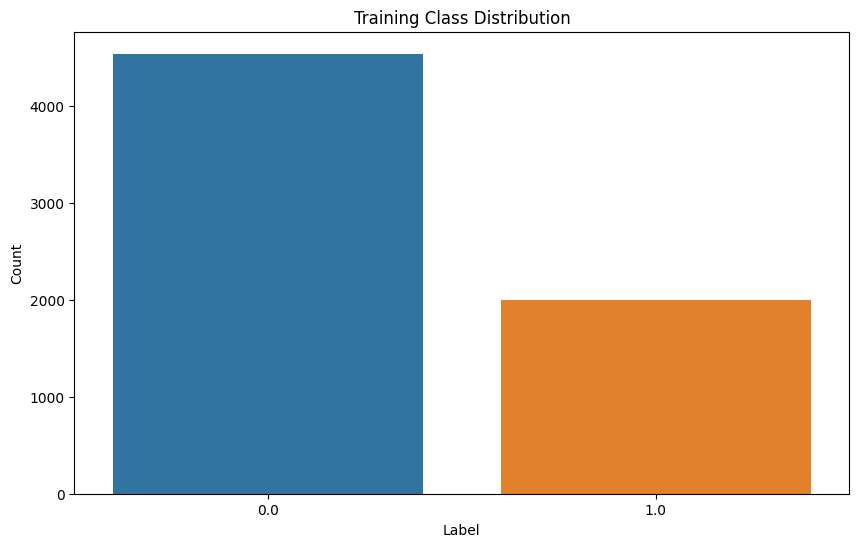

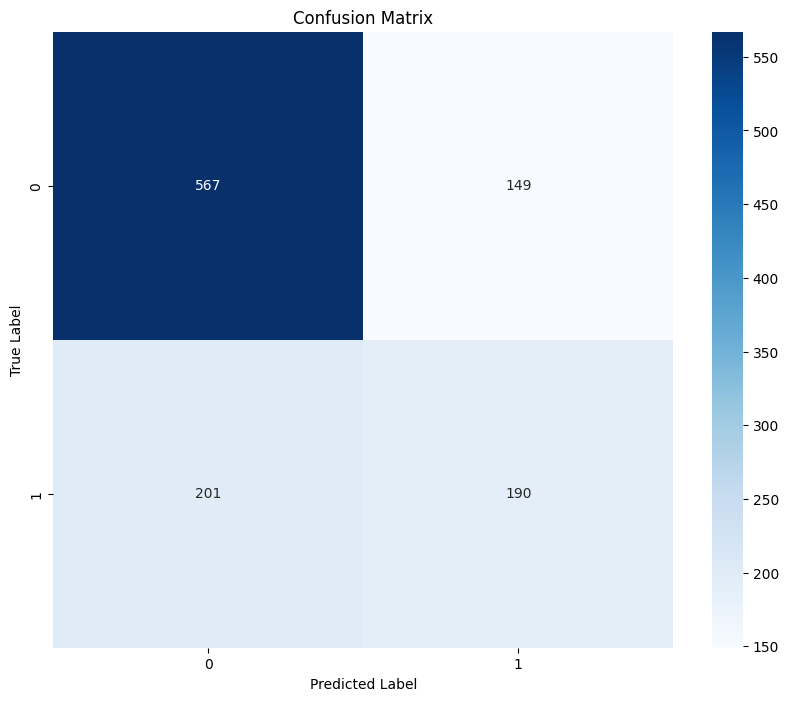

In [14]:
# Option 1: Training
train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_en_l2.csv"
test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l2.csv"
model, f1, report = train_english_classifier(train_file, test_file)
save_model(model, "english_series_classifier_model_l2.pkl")

# Option 2: Prediction
#model = joblib.load("english_series_classifier_model_l2.pkl")
#input_file = "/kaggle/input/your-dataset/new_data.csv"
#output_file = "predictions.csv"
#predict_on_new_data(model, input_file, output_file)

# Option 3: Sample prediction
model_path = "english_series_classifier_model_l2.pkl"
sample_text = "Your sample text here"
prediction_class, prediction_value, confidence = load_model_and_predict(
    model_path=model_path, sample_text=sample_text)
print(f"Class: {prediction_class}, Value: {prediction_value}, Confidence: {confidence:.4f}")

In [15]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import joblib
import os
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

# Create a custom transformer for sentence embeddings
class SentenceTransformerEmbedding(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return self.model.encode(X)
# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize, remove stopwords and lemmatize (optional - can be computational intensive)
    # Uncomment if you want this feature
    '''
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    '''
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

class TextEmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long)

# LSTM-RNN-GRU Series Model
class SeriesNeuralClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, dropout=0.2):
        super(SeriesNeuralClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, 
                            num_layers=1, dropout=0, 
                            batch_first=True)
        
        # RNN layer
        self.rnn = nn.RNN(hidden_dim, hidden_dim, 
                          num_layers=1, dropout=0, 
                          batch_first=True)
        
        # GRU layer
        self.gru = nn.GRU(hidden_dim, hidden_dim, 
                          num_layers=1, dropout=0, 
                          batch_first=True)
        
        # Final fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text shape: [batch size, embedding dim]
        # Reshaping to [batch size, 1, embedding dim] to simulate sequence length of 1
        text = text.unsqueeze(1)
        
        # Pass through LSTM
        lstm_out, (lstm_hidden, lstm_cell) = self.lstm(text)
        
        # Pass LSTM output through RNN
        rnn_out, rnn_hidden = self.rnn(lstm_out)
        
        # Pass RNN output through GRU
        gru_out, gru_hidden = self.gru(rnn_out)
        
        # Take the last hidden state from GRU
        hidden = gru_hidden[-1]
        hidden = self.dropout(hidden)
        
        # Pass through final layer
        output = self.fc(hidden)
        return output

class PyTorchSeriesNeuralWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=384, hidden_dim=128, dropout=0.2, n_layers=1, 
                 lr=0.001, epochs=10, batch_size=32, device=None):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.n_layers = n_layers
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.label_encoder = None
        self.classes_ = None
    
    def fit(self, X, y):
        # Encode labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_
        
        # Create dataset and loader
        dataset = TextEmbeddingDataset(X, y_encoded)
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Initialize model
        self.output_dim = len(self.label_encoder.classes_)
        self.model = SeriesNeuralClassifier(
            input_dim=self.input_dim, 
            hidden_dim=self.hidden_dim,
            output_dim=self.output_dim,
            n_layers=self.n_layers,
            dropout=self.dropout
        ).to(self.device)
        
        # Define optimizer and loss
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            print(f'Epoch {epoch+1}/{self.epochs}, Loss: {total_loss/len(train_loader):.4f}')
        
        return self
    
    def predict(self, X):
        self.model.eval()
        predictions = []
        
        # Create dataset and loader for predictions
        dummy_y = np.zeros(len(X))
        dataset = TextEmbeddingDataset(X, dummy_y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
        
        return self.label_encoder.inverse_transform(predictions)
    
    def predict_proba(self, X):
        self.model.eval()
        probabilities = []
        
        # Create dataset and loader for predictions
        dummy_y = np.zeros(len(X))
        dataset = TextEmbeddingDataset(X, dummy_y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                probabilities.extend(probs.cpu().numpy())
        
        return np.array(probabilities)

# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your English dataset
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_english_classifier(train_file, test_file=None):
    """
    Train an English text classifier using LSTM-RNN-GRU series and evaluate on test data.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_english_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('training_class_distribution.png')
        print("Class distribution plot saved as 'training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create a pipeline with Sentence Transformer embeddings and LSTM-RNN-GRU series model
        print("\nCreating and training the LSTM-RNN-GRU series model...")
        pipeline = Pipeline([
            ('embeddings', SentenceTransformerEmbedding()),
            ('classifier', PyTorchSeriesNeuralWrapper(
                input_dim=384,  # Default dimension for all-MiniLM-L6-v2
                hidden_dim=128,
                dropout=0.3,
                n_layers=2,
                lr=0.001,
                epochs=30,
                batch_size=32
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("LSTM-RNN-GRU series model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text
            print("Preprocessing test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_english_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix.png')
            print("Confusion matrix saved as 'confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions.csv', index=False)
            print("Test predictions saved to 'test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence (probability of the predicted class)
        confidence_values = []
        for i, pred_class in enumerate(predictions_class):
            class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
            confidence_values.append(prediction_probs[i][class_index])
        
        df['prediction_confidence'] = confidence_values
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def save_model(model, model_path='english_series_classifier_model.pkl'):
    """
    Save the trained model to a file
    
    Args:
        model: Trained classifier pipeline
        model_path: Path where to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model_and_predict(model_path='english_series_classifier_model.pkl', 
                          test_file=None, sample_text=None):
    """
    Load a trained model and use it for inference on a test file or sample text
    
    Args:
        model_path: Path to the saved model file
        test_file: Path to a CSV file containing texts to predict
        sample_text: A single text string to predict
        
    Returns:
        Predictions or a single prediction
    """
    try:
        # Load the model
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        
        if test_file and os.path.exists(test_file):
            # Predict on test file
            print(f"Predicting on test file: {test_file}")
            df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess text
            df['processed_text'] = df['text'].apply(preprocess_english_text)
            
            # Make predictions
            predictions_class = model.predict(df['processed_text'])
            predictions_value = [float(pred) for pred in predictions_class]
            
            # Get prediction probabilities
            prediction_probs = model.predict_proba(df['processed_text'])
            
            # Add predictions to dataframe
            df['predicted_label_class'] = predictions_class
            df['predicted_label_value'] = predictions_value
            
            # Add prediction confidence
            confidence_values = []
            for i, pred_class in enumerate(predictions_class):
                class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
                confidence_values.append(prediction_probs[i][class_index])
            
            df['prediction_confidence'] = confidence_values
            
            # Save results
            output_file = "series_model_predictions_output.csv"
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
            
            return df
            
        elif sample_text:
            # Predict on a single text
            print("Predicting on sample text...")
            processed_text = preprocess_english_text(sample_text)
            prediction_class = model.predict([processed_text])[0]
            prediction_value = float(prediction_class)
            
            # Get prediction probability
            prediction_prob = model.predict_proba([processed_text])[0]
            class_index = list(model.named_steps['classifier'].classes_).index(prediction_class)
            confidence = prediction_prob[class_index]
            
            print(f"Text: {sample_text}")
            print(f"Processed text: {processed_text}")
            print(f"Prediction (class): {prediction_class}")
            print(f"Prediction (value): {prediction_value}")
            print(f"Confidence: {confidence:.4f}")
            
            return prediction_class, prediction_value, confidence
        
        else:
            print("Error: Please provide either a test file or sample text.")
            return None
            
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()
        return None

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv...
Preprocessing training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    4309
1.0    2222
Name: count, dtype: int64
Class distribution plot saved as 'training_class_distribution.png'

Creating and training the LSTM-RNN-GRU series model...


Batches:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.5906
Epoch 2/30, Loss: 0.5554
Epoch 3/30, Loss: 0.5478
Epoch 4/30, Loss: 0.5425
Epoch 5/30, Loss: 0.5408
Epoch 6/30, Loss: 0.5356
Epoch 7/30, Loss: 0.5318
Epoch 8/30, Loss: 0.5237
Epoch 9/30, Loss: 0.5205
Epoch 10/30, Loss: 0.5108
Epoch 11/30, Loss: 0.4988
Epoch 12/30, Loss: 0.4798
Epoch 13/30, Loss: 0.4659
Epoch 14/30, Loss: 0.4435
Epoch 15/30, Loss: 0.4192
Epoch 16/30, Loss: 0.3951
Epoch 17/30, Loss: 0.3605
Epoch 18/30, Loss: 0.3249
Epoch 19/30, Loss: 0.2912
Epoch 20/30, Loss: 0.2550
Epoch 21/30, Loss: 0.2298
Epoch 22/30, Loss: 0.2084
Epoch 23/30, Loss: 0.1856
Epoch 24/30, Loss: 0.1609
Epoch 25/30, Loss: 0.1345
Epoch 26/30, Loss: 0.1197
Epoch 27/30, Loss: 0.1158
Epoch 28/30, Loss: 0.0917
Epoch 29/30, Loss: 0.0833
Epoch 30/30, Loss: 0.0747
LSTM-RNN-GRU series model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv...
Preprocessing test text...
Calculating majority vote for test labels...
Making predictions on 

Batches:   0%|          | 0/35 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.6306

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.78      0.75       699
         1.0       0.56      0.48      0.52       408

    accuracy                           0.67      1107
   macro avg       0.64      0.63      0.63      1107
weighted avg       0.66      0.67      0.66      1107

Confusion matrix saved as 'confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'test_predictions.csv'
Saving model to english_series_classifier_model_l3.pkl...
Model saved successfully to english_series_classifier_model_l3.pkl
Loading model from english_series_classifier_model_l3.pkl...
Model loaded successfully!
Predicting on sample text...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:714: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.rnn_tanh(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly gre

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: Your sample text here
Processed text: your sample text here
Prediction (class): 0.0
Prediction (value): 0.0
Confidence: 1.0000
Class: 0.0, Value: 0.0, Confidence: 1.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:714: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.rnn_tanh(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly gre

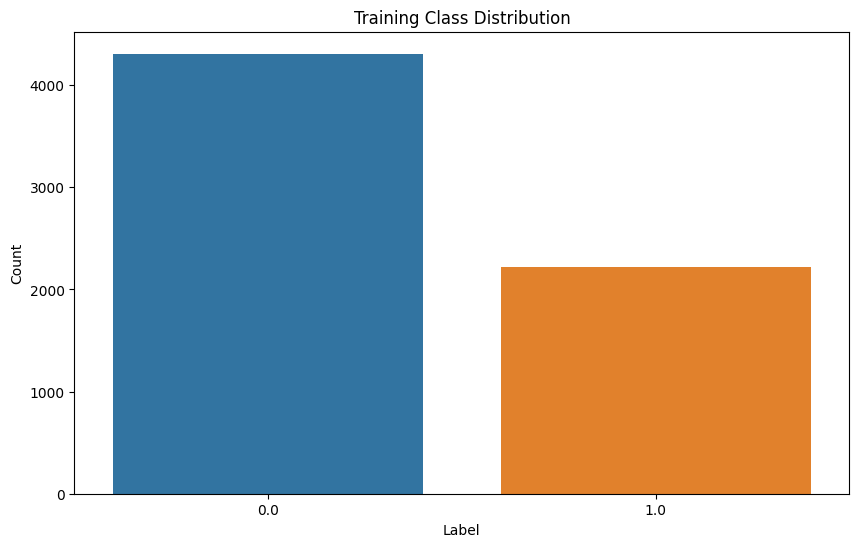

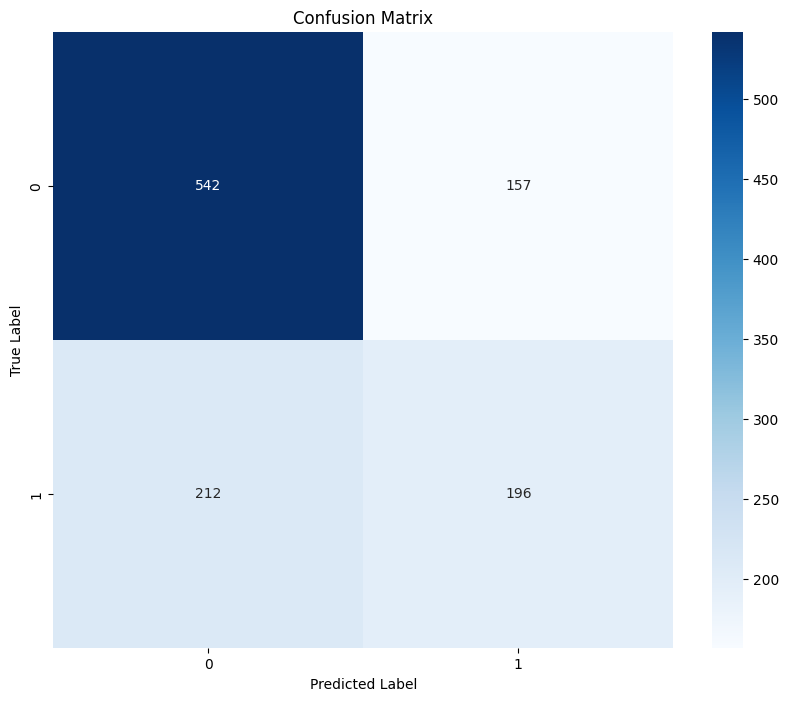

In [17]:
# Option 1: Training
train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv"
test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv"
model, f1, report = train_english_classifier(train_file, test_file)
save_model(model, "english_series_classifier_model_l3.pkl")

# Option 2: Prediction
#model = joblib.load("english_series_classifier_model_l2.pkl")
#input_file = "/kaggle/input/your-dataset/new_data.csv"
#output_file = "predictions.csv"
#predict_on_new_data(model, input_file, output_file)

# Option 3: Sample prediction
model_path = "english_series_classifier_model_l3.pkl"
sample_text = "Your sample text here"
prediction_class, prediction_value, confidence = load_model_and_predict(
    model_path=model_path, sample_text=sample_text)
print(f"Class: {prediction_class}, Value: {prediction_value}, Confidence: {confidence:.4f}")

In [22]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import joblib
import os
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add imports for PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.base import BaseEstimator, ClassifierMixin

# Define a PyTorch Dataset for our task
class SentenceDataset(Dataset):
    def __init__(self, texts, labels=None, sentence_transformer=None):
        self.texts = texts
        self.labels = labels
        self.sentence_transformer = sentence_transformer
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        
        # If labels are provided (for training/evaluation)
        if self.labels is not None:
            label = self.labels[idx]
            return text, torch.tensor(label, dtype=torch.float)
        
        # For inference only
        return text, None

# Define the LSTM-RNN-GRU sequential model
class SequentialNetworkClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers=1, dropout=0.2):
        super(SequentialNetworkClassifier, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # GRU layer
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, 1)
        
        # Activation function
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x shape: (batch_size, embedding_dim)
        # Reshape for sequential models which expect (batch_size, seq_len, features)
        x = x.unsqueeze(1)  # Add sequence dimension
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Pass LSTM output to RNN
        rnn_out, _ = self.rnn(lstm_out)
        
        # Pass RNN output to GRU
        gru_out, _ = self.gru(rnn_out)
        
        # Take the output of the last time step
        out = gru_out[:, -1, :]
        
        # Pass through linear layer
        out = self.fc(out)
        
        # Apply sigmoid for binary classification
        out = self.sigmoid(out)
        
        return out.squeeze()

# Scikit-learn compatible wrapper for our PyTorch model
class PyTorchSequentialWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, embedding_dim=384, hidden_dim=128, num_layers=1, 
                 dropout=0.2, batch_size=32, epochs=10, learning_rate=0.001):
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.model = None
        self.sentence_transformer = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classes_ = np.array([0, 1])  # Binary classification
        
    def _get_embeddings(self, texts):
        # Get sentence embeddings
        if isinstance(texts, pd.Series):
            texts = texts.tolist()
        return self.sentence_transformer.encode(texts)
    
    def fit(self, X, y):
        # Store sentence transformer from the previous step in the pipeline
        # This assumes it's passed from the SentenceTransformerEmbedder
        self.sentence_transformer = self._find_sentence_transformer(X)
        
        # Create dataset and dataloader
        X_embeddings = X if isinstance(X, np.ndarray) else self._get_embeddings(X)
        X_tensor = torch.tensor(X_embeddings, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y.values, dtype=torch.float32).to(self.device)
        
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Initialize model
        self.model = SequentialNetworkClassifier(
            embedding_dim=X_embeddings.shape[1],
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers,
            dropout=self.dropout
        ).to(self.device)
        
        # Define loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for inputs, labels in dataloader:
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            # Print epoch statistics
            if (epoch + 1) % 5 == 0:  # Print every 5 epochs
                print(f'Epoch {epoch+1}/{self.epochs}, Loss: {total_loss/len(dataloader):.4f}')
        
        return self
    
    def predict(self, X):
        if self.model is None:
            raise ValueError("Model has not been trained yet.")
        
        # Get embeddings if needed
        X_embeddings = X if isinstance(X, np.ndarray) else self._get_embeddings(X)
        X_tensor = torch.tensor(X_embeddings, dtype=torch.float32).to(self.device)
        
        # Switch to evaluation mode
        self.model.eval()
        
        # Predict without gradient calculation
        with torch.no_grad():
            outputs = self.model(X_tensor)
            predictions = (outputs >= 0.5).float().cpu().numpy()
        
        return predictions.astype(int)
    
    def predict_proba(self, X):
        if self.model is None:
            raise ValueError("Model has not been trained yet.")
        
        # Get embeddings if needed
        X_embeddings = X if isinstance(X, np.ndarray) else self._get_embeddings(X)
        X_tensor = torch.tensor(X_embeddings, dtype=torch.float32).to(self.device)
        
        # Switch to evaluation mode
        self.model.eval()
        
        # Predict probabilities without gradient calculation
        with torch.no_grad():
            raw_outputs = self.model(X_tensor).cpu().numpy()
            
        # Create probability matrix for both classes
        probas = np.zeros((len(raw_outputs), 2))
        probas[:, 0] = 1 - raw_outputs  # Class 0 probability
        probas[:, 1] = raw_outputs      # Class 1 probability
        
        return probas
    
    def _find_sentence_transformer(self, X):
        """Try to find the sentence transformer from the previous step"""
        if hasattr(X, 'model'):
            return X.model
        
        # If X is not an object with a model attribute, 
        # initialize a new SentenceTransformer
        from sentence_transformers import SentenceTransformer
        return SentenceTransformer('all-MiniLM-L6-v2')

# Custom transformer for sentence embeddings
class SentenceTransformerEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        print(f"Generating sentence embeddings using {self.model_name}...")
        # Convert pandas Series to list to avoid indexing issues
        if hasattr(X, 'tolist'):
            X_list = X.tolist()
        else:
            X_list = list(X)
        return self.model.encode(X_list)

def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Function to calculate majority vote for L1 dataset
def majority_vote_l1(row):
    # Extract annotation columns for L1
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

# Function to calculate majority vote for L3 dataset
def majority_vote_l3(row):
    # Extract annotation columns for L3
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_combined_classifier_sequential(l1_file, l3_file):
    """
    Train a sequential LSTM-RNN-GRU model using the combined L1 and L3 datasets.
    Final label is 1 if both L1 and L3 are 1, otherwise 0.
    
    Args:
        l1_file: Path to the L1 CSV file
        l3_file: Path to the L3 CSV file
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the L1 CSV file
        print(f"Reading L1 data from {l1_file}...")
        l1_df = pd.read_csv(l1_file, quoting=csv.QUOTE_MINIMAL)
        
        # Read the L3 CSV file
        print(f"Reading L3 data from {l3_file}...")
        l3_df = pd.read_csv(l3_file, quoting=csv.QUOTE_MINIMAL)
        
        # Ensure both datasets have a unique ID to match sentences
        if 'id' not in l1_df.columns:
            l1_df['id'] = range(len(l1_df))
        if 'id' not in l3_df.columns:
            l3_df['id'] = range(len(l3_df))
        
        # Calculate majority vote for L1 dataset
        print("Calculating majority vote for L1 labels...")
        l1_df['l1_label'] = l1_df.apply(majority_vote_l1, axis=1)
        
        # Calculate majority vote for L3 dataset
        print("Calculating majority vote for L3 labels...")
        l3_df['l3_label'] = l3_df.apply(majority_vote_l3, axis=1)
        
        # Extract essential columns from each dataset
        l1_subset = l1_df[['id', 'text', 'l1_label']]
        l3_subset = l3_df[['id', 'l3_label']]
        
        # Merge datasets on ID
        print("Merging L1 and L3 datasets...")
        merged_df = pd.merge(l1_subset, l3_subset, on='id', how='inner')
        
        # Determine final label: 1 if both L1 and L3 are 1, otherwise 0
        merged_df['final_label'] = ((merged_df['l1_label'] == 1.0) & 
                                    (merged_df['l3_label'] == 1.0)).astype(int)
        
        # Preprocess text column
        print("Preprocessing text...")
        merged_df['processed_text'] = merged_df['text'].apply(preprocess_english_text)
        
        # Print the class distribution
        print("\nFinal label class distribution:")
        class_dist = merged_df['final_label'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='final_label', data=merged_df)
        plt.title('Combined Dataset Class Distribution')
        plt.xlabel('Final Label (1 if both L1 and L3 are 1, otherwise 0)')
        plt.ylabel('Count')
        plt.savefig('combined_class_distribution_sequential.png')
        print("Class distribution plot saved as 'combined_class_distribution_sequential.png'")
        
        # Split into training and testing sets (80% train, 20% test)
        X = merged_df['processed_text']
        y = merged_df['final_label']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"Training data size: {len(X_train)}, Test data size: {len(X_test)}")
        
        
        print("\nCreating and training the model...")
        # Create the pipeline
        pipeline = Pipeline([
            ('sentence_embedding', SentenceTransformerEmbedder()),
            ('classifier', PyTorchSequentialWrapper(
                embedding_dim=384,  # Default dimension for 'all-MiniLM-L6-v2'
                hidden_dim=128,
                num_layers=2,
                dropout=0.3,
                batch_size=32,
                epochs=50,
                learning_rate=0.0001
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # Make predictions on test data
        print("\nMaking predictions on test data...")
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        print("\nEvaluating model performance...")
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        
        print(f"\nMacro F1 Score: {macro_f1:.4f}")
        print("\nDetailed Classification Report:")
        report = classification_report(y_test, y_pred)
        print(report)
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (LSTM-RNN-GRU Sequential)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig('confusion_matrix_sequential.png')
        print("Confusion matrix saved as 'confusion_matrix_sequential.png'")
        
        # Save test predictions
        print("\nSaving test predictions...")
        results_df = pd.DataFrame({
            'text': X_test.values,
            'true_label': y_test.values,
            'predicted_label': y_pred,
            'probability_class_1': pipeline.predict_proba(X_test)[:, 1]
        })
        results_df.to_csv('test_predictions_sequential.csv', index=False)
        print("Test predictions saved to 'test_predictions_sequential.csv'")
        
        # Save the combined dataset with all labels
        merged_df.to_csv('combined_dataset_with_labels_sequential.csv', index=False)
        print("Combined dataset saved to 'combined_dataset_with_labels_sequential.csv'")
        
        return pipeline, macro_f1, report
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Function to predict on new data
def predict_on_new_data_sequential(model, input_file, output_file):
    """
    Use a trained sequential model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions = model.predict(df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(df['processed_text'])
        
        # Add predictions to dataframe
        df['predicted_label'] = predictions
        df['probability_class_1'] = prediction_probs[:, 1]
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions).value_counts()
        print(pred_dist)
        
        # Plot probability distribution
        plt.figure(figsize=(10, 6))
        plt.hist(df['probability_class_1'], bins=20)
        plt.title('Prediction Probability Distribution (Class 1)')
        plt.xlabel('Probability')
        plt.ylabel('Count')
        plt.savefig('prediction_probability_sequential.png')
        print("Prediction probability plot saved as 'prediction_probability_sequential.png'")
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def evaluate_on_combined_test_data_sequential(model, l1_test_file, l3_test_file, output_file='combined_test_predictions_sequential.csv'):
    """
    Combine L1 and L3 test datasets, evaluate the sequential model, and save predictions.
    Final label is 1 if both L1 and L3 are 1, otherwise 0.
    
    Args:
        model: Trained classifier pipeline
        l1_test_file: Path to the L1 test CSV file
        l3_test_file: Path to the L3 test CSV file
        output_file: Path to save predictions
    
    Returns:
        Evaluation metrics and combined test dataframe
    """
    try:
        # Read the L1 test CSV file
        print(f"Reading L1 test data from {l1_test_file}...")
        l1_test_df = pd.read_csv(l1_test_file, quoting=csv.QUOTE_MINIMAL)
        
        # Read the L3 test CSV file
        print(f"Reading L3 test data from {l3_test_file}...")
        l3_test_df = pd.read_csv(l3_test_file, quoting=csv.QUOTE_MINIMAL)
        
        # Ensure both datasets have a unique ID to match sentences
        if 'id' not in l1_test_df.columns:
            l1_test_df['id'] = range(len(l1_test_df))
        if 'id' not in l3_test_df.columns:
            l3_test_df['id'] = range(len(l3_test_df))
        
        # Calculate majority vote for L1 test dataset
        print("Calculating majority vote for L1 test labels...")
        l1_test_df['l1_label'] = l1_test_df.apply(majority_vote_l1, axis=1)
        
        # Calculate majority vote for L3 test dataset
        print("Calculating majority vote for L3 test labels...")
        l3_test_df['l3_label'] = l3_test_df.apply(majority_vote_l3, axis=1)
        
        # Extract essential columns from each test dataset
        l1_test_subset = l1_test_df[['id', 'text', 'l1_label']]
        l3_test_subset = l3_test_df[['id', 'l3_label']]
        
        # Merge test datasets on ID
        print("Merging L1 and L3 test datasets...")
        merged_test_df = pd.merge(l1_test_subset, l3_test_subset, on='id', how='inner')
        
        # Determine final test label: 1 if both L1 and L3 are 1, otherwise 0
        merged_test_df['final_label'] = ((merged_test_df['l1_label'] == 1.0) & 
                                       (merged_test_df['l3_label'] == 1.0)).astype(int)
        
        # Preprocess text column
        print("Preprocessing test text...")
        merged_test_df['processed_text'] = merged_test_df['text'].apply(preprocess_english_text)
        
        # Print the test class distribution
        print("\nFinal test label class distribution:")
        test_class_dist = merged_test_df['final_label'].value_counts()
        print(test_class_dist)
        
        # Plot test class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='final_label', data=merged_test_df)
        plt.title('Combined Test Dataset Class Distribution')
        plt.xlabel('Final Label (1 if both L1 and L3 are 1, otherwise 0)')
        plt.ylabel('Count')
        plt.savefig('combined_test_class_distribution_sequential.png')
        print("Test class distribution plot saved as 'combined_test_class_distribution_sequential.png'")
        
        # Get test data
        X_test = merged_test_df['processed_text']
        y_test = merged_test_df['final_label']
        
        print(f"Test data size: {len(X_test)}")
        if model is None:
            print("Error: Model is None. Please ensure the model was trained successfully.")
            return None, None, None
        
        # Make predictions on test data
        print("\nMaking predictions on combined test data...")
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        print("\nEvaluating model performance on test data...")
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        
        print(f"\nMacro F1 Score on test data: {macro_f1:.4f}")
        print("\nDetailed Classification Report on test data:")
        test_report = classification_report(y_test, y_pred)
        print(test_report)
        
        # Create confusion matrix for test data
        test_cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Data Confusion Matrix (LSTM-RNN-GRU Sequential)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig('test_confusion_matrix_sequential.png')
        print("Test confusion matrix saved as 'test_confusion_matrix_sequential.png'")
        
        # Save test predictions
        print("\nSaving combined test predictions...")
        results_df = pd.DataFrame({
            'id': merged_test_df['id'],
            'text': X_test.values,
            'l1_label': merged_test_df['l1_label'],
            'l3_label': merged_test_df['l3_label'],
            'true_combined_label': y_test.values,
            'predicted_label': y_pred,
            'probability_class_1': model.predict_proba(X_test)[:, 1]
        })
        results_df.to_csv(output_file, index=False)
        print(f"Combined test predictions saved to '{output_file}'")
        
        # Plot probability distribution for test data
        plt.figure(figsize=(10, 6))
        plt.hist(results_df['probability_class_1'], bins=20)
        plt.title('Test Prediction Probability Distribution (Class 1)')
        plt.xlabel('Probability')
        plt.ylabel('Count')
        plt.savefig('test_prediction_probability_sequential.png')
        print("Test prediction probability plot saved as 'test_prediction_probability_sequential.png'")
        
        return macro_f1, test_report, results_df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Function to save the trained model
def save_model(model, model_path='trained_combined_classifier_sequential.joblib'):
    """
    Save the trained model to disk.
    
    Args:
        model: Trained classifier pipeline
        model_path: Path to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(model_path) if os.path.dirname(model_path) else '.', exist_ok=True)
        # Save the model
        joblib.dump(model, model_path)
        print(f"Model successfully saved to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        import traceback
        traceback.print_exc()
        return False

# Function to load a saved model and perform inference
def load_model_and_predict(model_path, text_samples):
    """
    Load a trained model and make predictions on sample text.
    
    Args:
        model_path: Path to the saved model
        text_samples: List of text strings to predict on
        
    Returns:
        DataFrame with predictions
    """
    try:
        # Load the model
        print(f"Loading model from {model_path}...")
        try:
            model = joblib.load(model_path)
            if model is None:
                print("Error: Loaded model is None")
                return None
            print("Model loaded successfully!")
        except Exception as e:
            print(f"Error loading model: {e}")
            return None
        
        
        # Create a dataframe from the text samples
        samples_df = pd.DataFrame({'text': text_samples})
        
        # Preprocess the text
        print("Preprocessing sample text...")
        samples_df['processed_text'] = samples_df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions on samples...")
        predictions = model.predict(samples_df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(samples_df['processed_text'])
        
        # Add predictions to dataframe
        samples_df['predicted_label'] = predictions
        samples_df['probability_class_1'] = prediction_probs[:, 1]
        
        # Display results
        print("\nPrediction Results:")
        for i, (text, pred, prob) in enumerate(zip(
            text_samples, predictions, prediction_probs[:, 1])):
            label = "Potential issue detected" if pred == 1 else "No issue detected"
            print(f"\nSample {i+1}:")
            print(f"Text: {text[:100]}..." if len(text) > 100 else f"Text: {text}")
            print(f"Prediction: {label} (Class {pred})")
            print(f"Confidence: {prob:.4f}")
        
        return samples_df
        
    except Exception as e:
        print(f"Error during model loading or prediction: {e}")
        import traceback
        traceback.print_exc()
        return None

# Demonstration inference function
def demo_inference(model_path='trained_combined_classifier_bilstm.joblib'):
    """
    Demonstrate model inference with sample texts.
    
    Args:
        model_path: Path to the saved model
    """
    # Sample texts to test the model
    sample_texts = [
        "This restaurant would not serve me because of my race.",
        "I really enjoyed the movie, it was entertaining from start to finish.",
        "They refused to hire me because I'm too old for the position.",
        "The weather today is quite pleasant, perfect for a walk in the park.",
        "This company consistently pays women less than men for the same work."
    ]
    
    # Run inference
    results = load_model_and_predict(model_path, sample_texts)
    
    # Save results to CSV if available
    if results is not None:
        results.to_csv('sample_predictions_bilstm.csv', index=False)
        print("\nSample predictions saved to 'sample_predictions_bilstm.csv'")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Starting series Classification Pipeline

Step 1: Training the series model on combined datasets...
Reading L1 data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv...
Reading L3 data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv...
Calculating majority vote for L1 labels...
Calculating majority vote for L3 labels...
Merging L1 and L3 datasets...
Preprocessing text...

Final label class distribution:
final_label
0    5400
1    1131
Name: count, dtype: int64
Class distribution plot saved as 'combined_class_distribution_sequential.png'
Training data size: 5224, Test data size: 1307

Creating and training the model...
Generating sentence embeddings using all-MiniLM-L6-v2...


Batches:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 5/50, Loss: 0.3704
Epoch 10/50, Loss: 0.3553
Epoch 15/50, Loss: 0.3442
Epoch 20/50, Loss: 0.3406
Epoch 25/50, Loss: 0.3360
Epoch 30/50, Loss: 0.3286
Epoch 35/50, Loss: 0.3275
Epoch 40/50, Loss: 0.3225
Epoch 45/50, Loss: 0.3234
Epoch 50/50, Loss: 0.3161
Model training complete!

Making predictions on test data...
Generating sentence embeddings using all-MiniLM-L6-v2...


Batches:   0%|          | 0/41 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.6590

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1081
           1       0.47      0.39      0.43       226

    accuracy                           0.82      1307
   macro avg       0.67      0.65      0.66      1307
weighted avg       0.81      0.82      0.81      1307

Confusion matrix saved as 'confusion_matrix_sequential.png'

Saving test predictions...
Generating sentence embeddings using all-MiniLM-L6-v2...


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Test predictions saved to 'test_predictions_sequential.csv'
Combined dataset saved to 'combined_dataset_with_labels_sequential.csv'

Training complete with Macro F1 Score: 0.6590

Step 2: Evaluating the model on combined test datasets...
Reading L1 test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv...
Reading L3 test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv...
Calculating majority vote for L1 test labels...
Calculating majority vote for L3 test labels...
Merging L1 and L3 test datasets...
Preprocessing test text...

Final test label class distribution:
final_label
0    911
1    196
Name: count, dtype: int64
Test class distribution plot saved as 'combined_test_class_distribution_sequential.png'
Test data size: 1107

Making predictions on combined test data...
Generating sentence embeddings using all-MiniLM-L6-v2...


Batches:   0%|          | 0/35 [00:00<?, ?it/s]


Evaluating model performance on test data...

Macro F1 Score on test data: 0.6818

Detailed Classification Report on test data:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       911
           1       0.54      0.40      0.46       196

    accuracy                           0.83      1107
   macro avg       0.71      0.66      0.68      1107
weighted avg       0.82      0.83      0.82      1107

Test confusion matrix saved as 'test_confusion_matrix_sequential.png'

Saving combined test predictions...
Generating sentence embeddings using all-MiniLM-L6-v2...


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Combined test predictions saved to 'combined_test_predictions_series.csv'
Test prediction probability plot saved as 'test_prediction_probability_sequential.png'

Test evaluation complete with Macro F1 Score: 0.6818

Step 3: Saving the trained model...
Saving model to trained_combined_classifier_series.joblib...
Model successfully saved to trained_combined_classifier_series.joblib

Step 4: Running inference on sample texts...
Loading model from trained_combined_classifier_series.joblib...
Model loaded successfully!
Preprocessing sample text...
Making predictions on samples...
Generating sentence embeddings using all-MiniLM-L6-v2...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating sentence embeddings using all-MiniLM-L6-v2...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:714: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.rnn_tanh(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly gre

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Prediction Results:

Sample 1:
Text: This restaurant would not serve me because of my race.
Prediction: No issue detected (Class 0)
Confidence: 0.0632

Sample 2:
Text: I really enjoyed the movie, it was entertaining from start to finish.
Prediction: No issue detected (Class 0)
Confidence: 0.0029

Sample 3:
Text: They refused to hire me because I'm too old for the position.
Prediction: No issue detected (Class 0)
Confidence: 0.0124

Sample 4:
Text: The weather today is quite pleasant, perfect for a walk in the park.
Prediction: No issue detected (Class 0)
Confidence: 0.0029

Sample 5:
Text: This company consistently pays women less than men for the same work.
Prediction: No issue detected (Class 0)
Confidence: 0.3485

Sample predictions saved to 'sample_predictions_bilstm.csv'

Step 5: Additional options (uncomment in the code to use):
- To predict on a new dataset: predict_on_new_data_bilstm(model, 'new_data.csv', 'predictions.csv')
- To load a saved model: loaded_model = joblib.load(

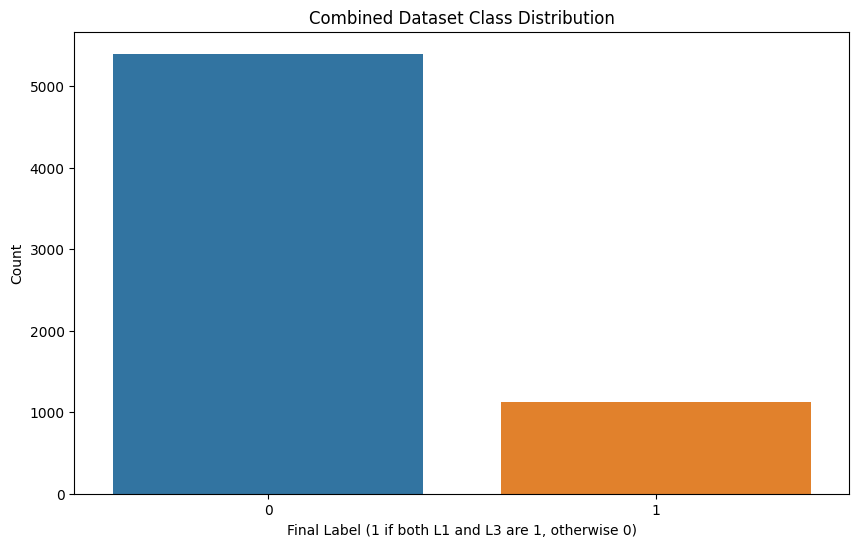

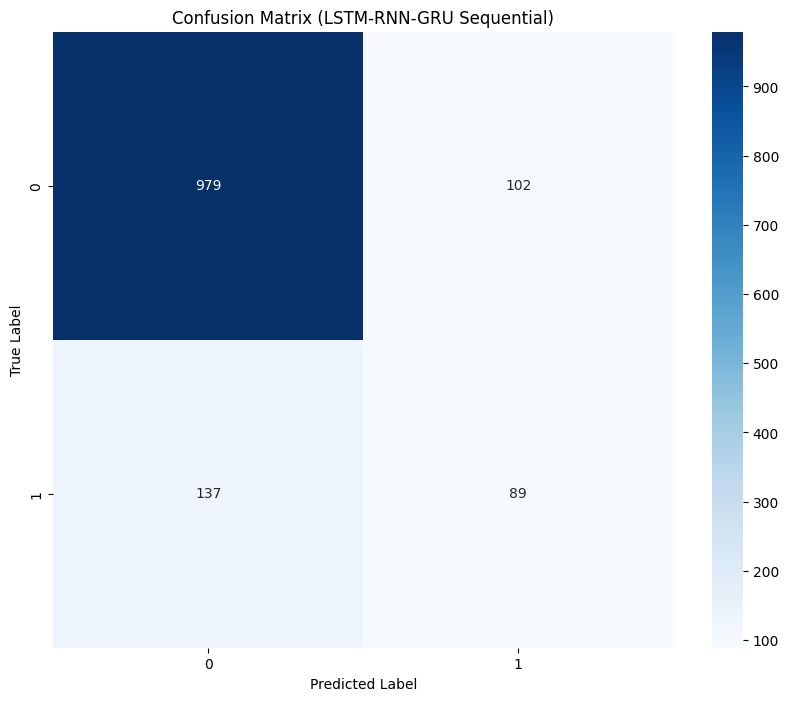

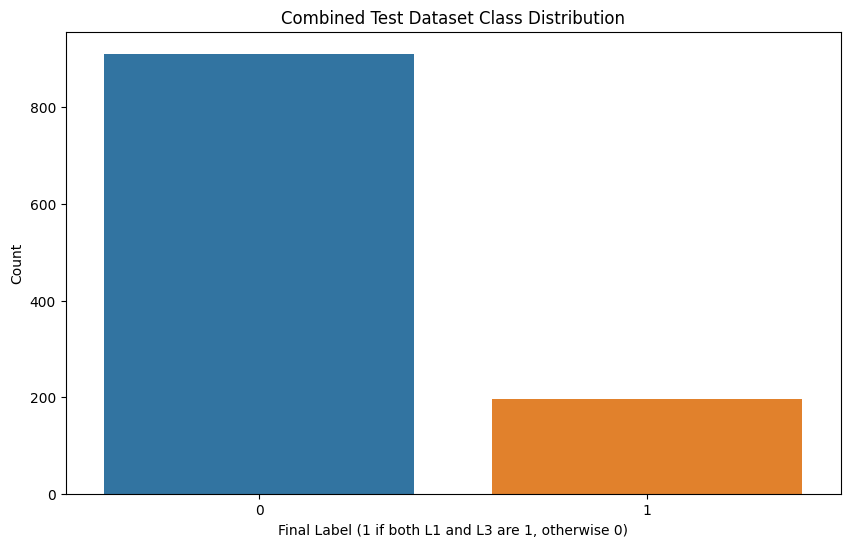

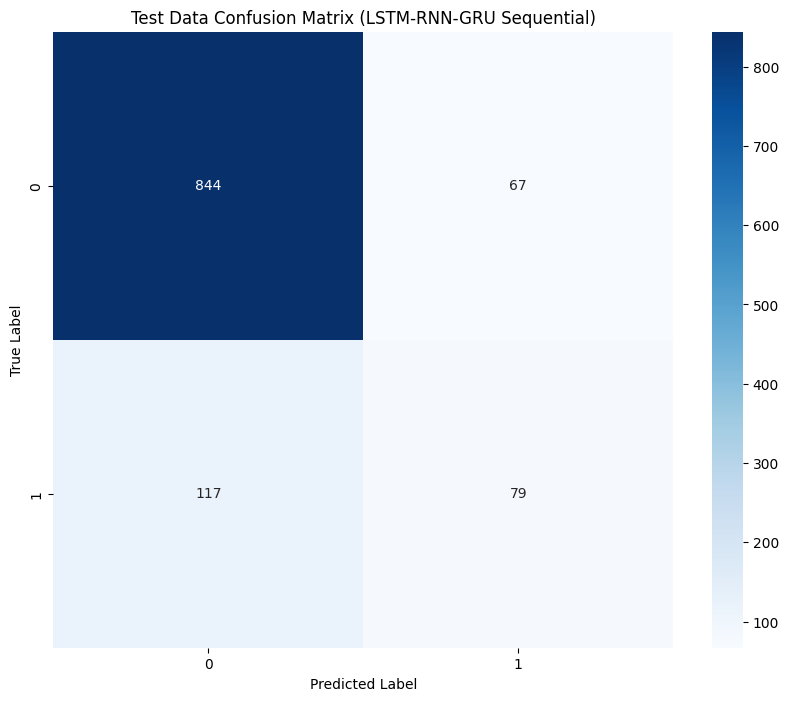

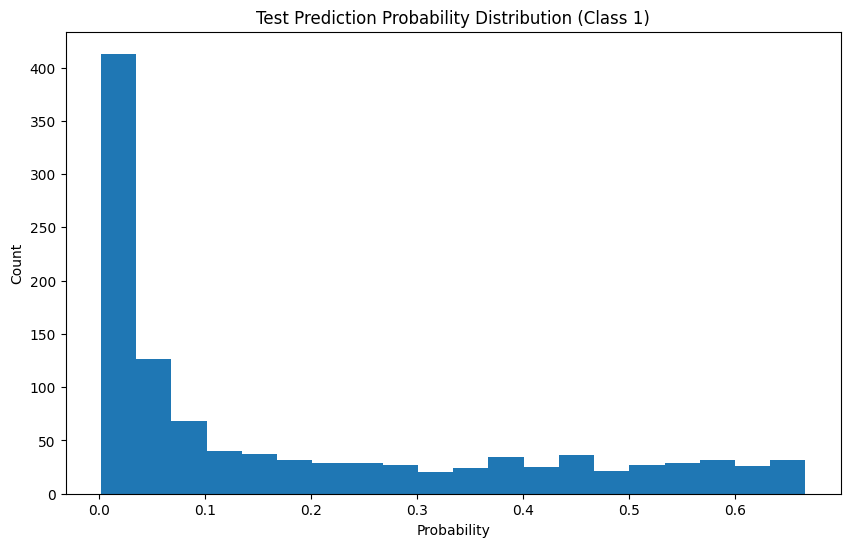

In [23]:
def main():
    """
    Main function to run the entire pipeline:
    1. Train the series model on combined L1 and L3 datasets
    2. Evaluate the model on test data
    3. Save the model
    4. Run inference on sample texts
    """
    print("="*80)
    print("Starting series Classification Pipeline")
    print("="*80)
    
    # Set paths to your data files
    l1_train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv"  # Path to L1 training data
    l3_train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv"  # Path to L3 training data
    l1_test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv"    # Path to L1 test data
    l3_test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv"    # Path to L3 test data
    model_save_path = "trained_combined_classifier_series.joblib"
    
    # Step 1: Train the model
    print("\nStep 1: Training the series model on combined datasets...")
    model, f1_score, report = train_combined_classifier_sequential(
        l1_train_file, 
        l3_train_file
    )
    
    if model is None:
        print("Error: Model training failed. Exiting.")
        return
    
    print(f"\nTraining complete with Macro F1 Score: {f1_score:.4f}")
    
    # Step 2: Evaluate on test data
    print("\nStep 2: Evaluating the model on combined test datasets...")
    test_f1, test_report, test_results = evaluate_on_combined_test_data_sequential(
        model,
        l1_test_file,
        l3_test_file,
        output_file='combined_test_predictions_series.csv'
    )
    
    if test_f1 is None:
        print("Error: Model evaluation failed.")
    else:
        print(f"\nTest evaluation complete with Macro F1 Score: {test_f1:.4f}")
    
    # Step 3: Save the model
    print("\nStep 3: Saving the trained model...")
    save_success = save_model(model, model_path=model_save_path)
    
    if not save_success:
        print("Error: Failed to save the model.")
    
    # Step 4: Run inference on sample texts
    print("\nStep 4: Running inference on sample texts...")
    demo_inference(model_path=model_save_path)
    
    print("\nStep 5: Additional options (uncomment in the code to use):")
    print("- To predict on a new dataset: predict_on_new_data_bilstm(model, 'new_data.csv', 'predictions.csv')")
    print("- To load a saved model: loaded_model = joblib.load('trained_combined_classifier_series.joblib')")
    
    print("\nAll steps completed!")
    
    return model  # Return the model for further use if needed


# Sample usage of additional functions (for reference):
"""
# To predict on a new dataset
new_data_file = "new_data.csv"  # Path to new data
predictions_file = "predictions_bilstm.csv"  # Path to save predictions
predict_on_new_data_bilstm(model, new_data_file, predictions_file)

# To load a saved model and make predictions
loaded_model = joblib.load("trained_combined_classifier_bilstm.joblib")
sample_texts = [
    "This restaurant would not serve me because of my race.",
    "I really enjoyed the movie, it was entertaining from start to finish."
]
predictions = load_model_and_predict("trained_combined_classifier_bilstm.joblib", sample_texts)
"""

# Execute main function when script is run directly
if __name__ == "__main__":
    main()